# What is a Bayes net?

A Bayes net - or Bayesian network - is a probabilistic graphical model, or PGM. It is a simple and intuitive way to represent a joint probability distribution by specifying conditional probability distributions for the underlying variables in the network. Bayes nets can represent both discrete and continuous variables, though we will focus initially on networks with only discrete variables. 

We'll use two toy examples to explore the implementation.

1. The alarm network: https://github.com/jpmcarrilho/AIMA/blob/master/probability-4e.ipynb 
    _The story, from Judea Pearl, is that there is a house burglar alarm, which can be triggered by either a burglary or an earthquake. If the alarm sounds, one or both of the neighbors, John and Mary, might call the owner to say the alarm is sounding._

# Representing a Bayes net in code

Conceptually a Bayes net is simple; all we need is the node mappings, or dependencies, and the probabilities that define the conditional / unconditional probability distributions.  

In terms of defining a structure, we will look to capture the key attributes.

|Attribute |Description| 
|-----|-----|
| _names_ |Maps a convenient shorthand node label to the to the full text e.g. A for Alarm  |
|_dependencies_|Maps nodes to their dependents |
|_parents_|Maps nodes to their parents |
|_conditional_probabilities_|Maps nodes to their conditional probabilities |
|_independent_nodes_|Set of nodes with no parents |
|_leaf_nodes_|Set of nodes with no dependencies |

We can use a dataclass to represent this structure for the two examples. In this case we are constructing the network manually, but later we will generalise the process such that the structure can be generated from a minimal representation i.e. the conditional probabilities. For now the conditional probabilities will be set as None.

In [944]:
from dataclasses import dataclass


@dataclass
class BayesNet:
    """Class for representing a Bayes net."""
    names: dict
    dependencies: dict
    parents: dict
    conditional_probabilities: dict
    all_nodes: set
    independent_nodes: set
    leaf_nodes: set

In [945]:
bayesnet_alarm = BayesNet(names={
    'B': 'Burglary',
    'E': 'Earthquake',
    'A': 'Alarm',
    'M': 'Mary calls',
    'J': 'John calls'
},
    dependencies={
    'B': ['A'],
    'E': ['A'],
    'A': ['M', 'J']
},
    parents={
    'M': ['A'],
    'J': ['A'],
    'A': ['B', 'E']
},
    conditional_probabilities=None,
    all_nodes={'B', 'E', 'A', 'M', 'J'},
    independent_nodes={'B', 'E'},
    leaf_nodes={'M', 'J'})

# Visualising a Bayes net

Seeing a network makes it easier to interpret. The package graphviz is a useful tool to help us; all we need to do is specify the nodes, and the edges between nodes, which we can extract from the attributes.

In [946]:
import graphviz


def visualise_bn(bn: BayesNet, use_full_names: bool):
    """Visualises Bayes net object."""
    g = graphviz.Digraph()
    for node, next_nodes in bn.dependencies.items():
        for nn in next_nodes:
            if use_full_names:
                g.edge(bn.names[node], bn.names[nn])
            else:
                g.edge(node, nn)
    return g

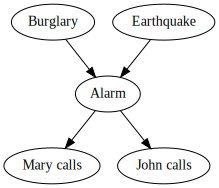

In [947]:
visualise_bn(bn=bayesnet_alarm, use_full_names=True)

# Specifying the joint probability distribution via conditional probabilities

Thus far we've looked at Bayes nets as graphs, focusing on the nodes and the dependencies between nodes. The tricky bit of a Bayes net is how to succinctly and efficiently represent and work with the conditional probabilities. We can use a CSV format to specify the key information, which we have done for the key examples in data/conditional_probabilities_alarm.csv.

We read these into a Pandas data-frame: 

In [948]:
import pandas as pd
with open('../data/conditional_probabilities_alarm.csv', 'r') as f:
    conditional_probabilities_df_alarm = pd.read_csv(f)

conditional_probabilities_df_alarm

,node,p,conditionals
0,B,0.001,None
1,E,0.002,None
2,A,0.950,B=1;E=1
3,A,0.940,B=1;E=0
4,A,0.290,B=0;E=1
5,A,0.001,B=0;E=0
6,J,0.900,A=1
7,J,0.050,A=0
8,M,0.700,A=1
9,M,0.010,A=0


Each distribution is specified on one row. For independent nodes - B & E - there is no conditioning, hence one line defines the complete and unconditional probability. A requires four rows, since it has two parent nodes, each of which can take two values. J and M each have one parent, so require two rows.

We have given minimal info thus far, and each row is implicitly a Bernoulli distribution, with the probability corresponding to the parameter generally taken as p. For the moment we will assume Bernoulli distributions, and examine later how we can generalise this.

# Simulating a Bayes net

This functionality is generally in line with the proof-of-concept Excel model. If you haven't seen that, it may be useful to take a look as that gives decent intuition into how and why the simulation functionality is set out.

## Random numbers

In [949]:
with open('../excel/fixed_random_numbers_100k.csv', 'r') as f:
    random_numbers = pd.read_csv(f)
N = random_numbers.shape[0]

random_numbers = 1 - random_numbers  # to align Excel and ppf
random_numbers.head()

,B,E,A,M,J
0,0.946102,0.578330,0.741226,0.365127,0.833227
1,0.998269,0.157830,0.723855,0.279586,0.861028
2,0.537858,0.691179,0.728596,0.346864,0.346127
3,0.420817,0.045270,0.658436,0.841218,0.978299
4,0.762577,0.817734,0.442690,0.748229,0.558408


## Representing conditional distributions

In [950]:
from typing import Optional, List, Callable, Tuple


@dataclass
class ConditionalDistribution:
    """Class for representing a conditional distribution."""
    conditionals: Optional[List[Tuple[str, int]]]
#     parameters: Tuple[str, float]
    ppf: Callable

In [951]:
from scipy.stats import bernoulli

conditional_distributions = {
    'B': [
        ConditionalDistribution(conditionals=None,
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.001)).astype(int))
    ],
    'E': [
        ConditionalDistribution(conditionals=None,
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.002)).astype(int))
    ],
    'A': [
        ConditionalDistribution(conditionals=[('B', 0), ('E', 0)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.001)).astype(int)),
        ConditionalDistribution(conditionals=[('B', 0), ('E', 1)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.29)).astype(int)),
        ConditionalDistribution(conditionals=[('B', 1), ('E', 0)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.94)).astype(int)),
        ConditionalDistribution(conditionals=[('B', 1), ('E', 1)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.95)).astype(int))
    ],
    'M': [
        ConditionalDistribution(conditionals=[('A', 0)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.01)).astype(int)),
        ConditionalDistribution(conditionals=[('A', 1)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.7)).astype(int))
    ],
    'J': [
        ConditionalDistribution(conditionals=[('A', 0)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.05)).astype(int)),
        ConditionalDistribution(conditionals=[('A', 1)],
                                ppf=lambda x:
                                (bernoulli.ppf(x, p=0.9)).astype(int))
    ]
}

## Ordering the simulation of variables

Intuitively we know how to simulate the nodes in the alarm network: B and E followed by A, then M and J. With this ordering we know the conditional variable values as required when we get to a node with parents. In general, especially for larger networks, we cannot do this by hand. 

The function below creates a valid ordering by inserting nodes one at a time, and ordering them relative to any parents and/or dependencies already in the list. May be a better way to do this....! 

In [952]:
def generate_simulation_order(bn: BayesNet):

    nodes_to_add = bn.all_nodes.copy()
    num_nodes = len(nodes_to_add)
    nodes_to_simulate = []

    while nodes_to_add:
        node = nodes_to_add.pop()
        parents = bn.parents.get(node, None)

        # insert one beyond last parent, using -1 as index for no parents (or no parents in list)
        if parents is not None:
            parents_in_list = [
                nodes_to_simulate.index(p) if p in nodes_to_simulate else -1
                for p in parents
            ]
            max_parent = max(parents_in_list)
        else:
            max_parent = -1

        nodes_to_simulate.insert(max_parent + 1, node)

    return nodes_to_simulate

We can check this gives a valid ordering for the alarm problem. We can interchage B and E in the first two slots, and M and J in the last two slots.

In [953]:
simulation_order = generate_simulation_order(bayesnet_alarm)
simulation_order

['E', 'B', 'A', 'J', 'M']

## Simulating independent variables

Independent variables can be simulated directly. We use the percentile-point function - or ppf - of the object to map the random number input into random variates of 1 and 0; these represent instances of where the variable has (1) or has not occurred (0).

We can demo this for the variables B and E. Starting with an empty dataframe, we iterate over the independent variables and join the output into a single dataframe.

In [954]:
random_variates = pd.DataFrame()
for var in ['B', 'E']:
    if len(conditional_distributions[var]) == 1:
        # no condtionals, append to existing output
        random_variates = pd.concat([
            random_variates,
            pd.DataFrame({
                var:
                conditional_distributions[var][0].ppf(random_numbers[var])
            })
        ],
            axis=1)
    else:
        # to be defined
        pass

random_variates

,B,E
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,0,0
99996,0,0
99997,0,0
99998,0,0


Due to the low probabilities that a burglary or earthquake occurs, the arrays are mostly zeros. We can sense check that the results are correct by summing the arrays. Given probabilities of 0.1% and 0.2%, respectively, for burglaries and earthquakes, we would expect sums of close to 10 and 20.

In [955]:
random_variates.sum()

B     91
E    194
dtype: int64

## Simulating conditional variables

Simulating conditional variables is a little more involved. We apply a two step approach, where we simluate conditional distributions as we did for the independent variables, but also use simulate the actual events. The latter requires the random variates constructed to date. 

We will demo this with the alarm variable, A.

In [956]:
var = 'A'

### Conditional random variates

Create a Pandas dataframe for each conditional distribution, using the list of conditionals as the column keys. There are lots of 1s, which indicate the alarm going off, but these are contingent on one or both of a burglary or earthquake occurring. 

In [957]:
conditional_random_variates = pd.concat([
    pd.DataFrame({str(cd.conditionals): cd.ppf(random_numbers[var])})
    for cd in conditional_distributions[var]
],
    axis=1)

conditional_random_variates

,"[('B', 0), ('E', 0)]","[('B', 0), ('E', 1)]","[('B', 1), ('E', 0)]","[('B', 1), ('E', 1)]"
0,0,1,1,1
1,0,1,1,1
2,0,1,1,1
3,0,0,1,1
4,0,0,1,1
...,...,...,...,...
99995,0,0,1,1
99996,0,0,1,1
99997,0,0,1,1
99998,0,0,1,1


In [958]:
conditional_random_variates.sum()
# conditional_random_variates.to_clipboard()

[('B', 0), ('E', 0)]      107
[('B', 0), ('E', 1)]    29109
[('B', 1), ('E', 0)]    94086
[('B', 1), ('E', 1)]    95103
dtype: int64

### Actual events

Use the same format - a Pandas dataframe with the conditionals as column keys - to create the array of actual events. This is again a series of 1s and 0s, but these represent whether a conditional event has occurred. e.g. whether there has been no burglary and no earthquake.

For this purpose we first define a separate function to generate the actual events.

In [959]:
def generate_actual_events(conditionals: List[Tuple[str, int]],
                           random_variates: pd.DataFrame) -> np.array:
    """
    Given a list of conditional (variable, value) pairs and a dataframe of random variates (1s and 0s),
    this function generates flags for whether the conditional is met
    e.g. given [('B', 0),('E', 0)], the return value is 1 where B and E are 0, and 0 elsewhere.

    Return Numpy array of 1s and 0s.
    """
    number_conditionals = len(conditionals)
    number_variates = random_variates.shape[0]
    outcomes = np.zeros((number_variates, number_conditionals)).astype(int)
    for i, (variable, value) in enumerate(conditionals):
        outcomes[:, i] = (random_variates[variable] == value) * 1

    return np.product(outcomes, axis=1)


assert np.all(
    generate_actual_events(conditionals=[('B', 0), ('E', 0)],
                           random_variates=pd.DataFrame({
                               'B': [0, 0, 1, 1],
                               'E': [0, 1, 0, 1]
                           })) == np.array([1, 0, 0, 0]))

Now apply the same pattern as before.

In [960]:
actual_events = pd.concat([
    pd.DataFrame({
        str(cd.conditionals):
        generate_actual_events(cd.conditionals, random_variates)
    }) for cd in conditional_distributions[var]
],
    axis=1)

actual_events

,"[('B', 0), ('E', 0)]","[('B', 0), ('E', 1)]","[('B', 1), ('E', 0)]","[('B', 1), ('E', 1)]"
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
99995,1,0,0,0
99996,1,0,0,0
99997,1,0,0,0
99998,1,0,0,0


The count of actual events is another sense check. 99.7% of the time there is no burglary or earthquake.

In [961]:
actual_events.sum()

[('B', 0), ('E', 0)]    99715
[('B', 0), ('E', 1)]      194
[('B', 1), ('E', 0)]       91
[('B', 1), ('E', 1)]        0
dtype: int64

###  Multiply and row-sum

The final step is to multiply then row-sum the two dataframes together. Multiplying the two together gives the random variates for the variable, in this case the alarm, A. It is no longer conditional, since the actual events have acted as a filter, by zeroising all but one entry. It can be a little confusing that the entry which is not zeroised, may also be zero.

Applying a row-sum returns this as the simulated value for A. We can then join this to the independent random variates already created for B and E.

In [962]:
random_variates_A = pd.DataFrame(
    {'A': (conditional_random_variates * actual_events).sum(axis=1)})
random_variates = pd.concat([random_variates, random_variates_A], axis=1)
random_variates.sum()

B     91
E    194
A    250
dtype: int64

## Combining independent and conditional variables

Now we can simulate both variable types separately.

In [963]:
random_variates = pd.DataFrame()
for var in ['B', 'E', 'A', 'M', 'J']:
    if len(conditional_distributions[var]) == 1:
        # no condtionals, append to existing output
        random_variates = pd.concat([
            random_variates,
            pd.DataFrame({
                var:
                conditional_distributions[var][0].ppf(random_numbers[var])
            })
        ],
            axis=1)
    else:
        conditional_random_variates = pd.concat([
            pd.DataFrame({str(cd.conditionals): cd.ppf(random_numbers[var])})
            for cd in conditional_distributions[var]
        ],
            axis=1)

        actual_events = pd.concat([
            pd.DataFrame({
                str(cd.conditionals):
                generate_actual_events(cd.conditionals, random_variates)
            }) for cd in conditional_distributions[var]
        ],
            axis=1)

        random_variates = pd.concat([
            random_variates,
            pd.DataFrame({
                var: (conditional_random_variates * actual_events).sum(axis=1)
            })
        ],
            axis=1)

random_variates.sum()

B      91
E     194
A     250
M    1191
J    5120
dtype: int64

### Adding non-events

What can be useful to consider is non-events e.g. the event that an earthquake did not happen. Given the random variates output, this is straightforward. 

In [964]:
random_variates_negation = random_variates.copy()
random_variates_negation.columns = [
    '¬' + x for x in random_variates_negation.columns
]
random_variates_negation = 1 - random_variates_negation

random_variates = pd.concat([random_variates, random_variates_negation],
                            axis=1)
random_variates.sum()

B        91
E       194
A       250
M      1191
J      5120
¬B    99909
¬E    99806
¬A    99750
¬M    98809
¬J    94880
dtype: int64

# Interpreting the output from a Bayes network

## Approximating P(X|Y)

In [965]:
all_vars = random_variates.columns
count_x_and_y = {}
count_y = {}
for y in all_vars:
    count_y[y] = random_variates[y].sum()
    for x in all_vars:
        count_x_and_y[(x, y)] = (random_variates[x] * random_variates[y]).sum()

full_names = {
    'B': 'Burglary',
    'E': 'Earthquake',
    'A': 'Alarm',
    'M': 'Mary calls',
    'J': 'John Calls',
    '¬B': 'No burglary',
    '¬E': 'No earthquake',
    '¬A': 'No alarm',
    '¬M': 'Mary does not call',
    '¬J': 'John does not call'
}

summary_probabilities_df = pd.concat([
    pd.DataFrame(
        {
            'Label': f'P({x}|{y})',
            'Event X': full_names[x],
            'Event Y': full_names[y],
            'Count X & Y': cxy,
            'Count Y': count_y[y],
            'Estimate for P(X|Y)': cxy / count_y[y]
        },
        index=[0]) for ((x, y), cxy) in count_x_and_y.items()
])

summary_probabilities_df.set_index('Label', inplace=True)

Should the homeowner be concerned about a burglary or an earthquake if Mary or John call? Not hugely. But what if both neighbours call?

In [966]:
summary_probabilities_df.loc[['P(B|M)', 'P(E|M)', 'P(B|J)', 'P(E|J)'], :]

,Event X,Event Y,Count X & Y,Count Y,Estimate for P(X|Y)
Label,,,,,
P(B|M),Burglary,Mary calls,52,1191,0.043661
P(E|M),Earthquake,Mary calls,44,1191,0.036944
P(B|J),Burglary,John Calls,78,5120,0.015234
P(E|J),Earthquake,John Calls,62,5120,0.012109


## Generalise to any event combinations

The code above generates all X-Y combinations for single variables, including their negations. In general we will also be interested in combinations of events. For the alarm example, the homeowner may be interested in the probability of a burglary given that both Mary and John call.

The approach is similar to above, except we specify the events via a list. Using the same terminology as above, we will use X to represent the event that a burglary has occured, and Y as the event that both Mary and John have called. We could also create the combined events into new variables, as we did for negation, then allow the code above to capture all combinations.

As the size of the network increases, it may not be possible, or practical, to print every X-Y combination, including negations and pairs, triples or higher. Hence having an easy way to estimate soecific probabilities in a generic manner remains useful. 

In [967]:
x = ['B']
y = ['M', 'J']
x_and_y = x + y

count_y = np.product(random_variates.loc[:, y], axis=1).sum()
count_x_and_y = np.product(random_variates.loc[:, x_and_y], axis=1).sum()

print(
    f'Number of times both neighbours call:                          {count_y}'
)
print(
    f'Number of times both neighbours call, and there is a burglary: {count_x_and_y}'
)
print(
    f'Estimated probability of burglary given both call:             {count_x_and_y / count_y :.2f}'
)

Number of times both neighbours call:                          202
Number of times both neighbours call, and there is a burglary: 48
Estimated probability of burglary given both call:             0.24


So still less likely to be a burglary than no burglary, but a greater concern than if only one person has called. We can extemd the extend the functionality further by considering 3 types of groupings:
- All events happening
- Any events happening
- Not any events happening

This follows the same approach as above, but we substitute logical Numpy functions in place of np.product, though we do need to re-type the result to an integer. Given the random variate output, this allows the user to estimate any probability, not withstanding any memory or speed issues.

In [968]:
count_A_M_J_all = np.all(random_variates.loc[:, ['A', 'M', 'J']],
                         axis=1).astype(int).sum()
count_A_M_J_any = np.any(random_variates.loc[:, ['A', 'M', 'J']],
                         axis=1).astype(int).sum()
count_A_M_J_not_any = np.logical_not(
    np.any(random_variates.loc[:, ['A', 'M', 'J']], axis=1)).astype(int).sum()

print(count_A_M_J_all)
print(count_A_M_J_any)
print(count_A_M_J_not_any)

155
6117
93883


# Parsing conditional distributions from CSV input

For the alarm network we constructed the conditional probabilities by hand. For the code to be extendable to other problems, we would like the user to be able to specify their own Bayes net via CSV input. We set out what this might look like earlier, and we will now try to parse that input - read into a dataframe - into an equivalent representation to the one we did by hand.

Comparing this to the _conditional_distributions_ variable, we can try to do this as follows:
- extract the unique nodes
- create an dictionary mapping nodes to an initially empty list
- parse each row into a _ConditionalDistribution_ object and append to the appropriate variable

<!-- As part of this parser, we will also take the opportunity to check that the supplied input is self-consistent. As a reminder, the inputs are:  -->

In [979]:
def parse_conditional_distributions(conditional_probabilities_df: pd.DataFrame):

    unique_nodes = conditional_probabilities_df['node'].unique()
    conditional_distributions = {node: [] for node in unique_nodes}

    for i, row in conditional_probabilities_df_alarm.iterrows():

        node = row['node']
        p = row['p']
        conditionals = row['conditionals']

        if conditionals == 'None':
            conditional_distributions[node].append(
                ConditionalDistribution(conditionals=None,
                                        ppf=lambda x:
                                        (bernoulli.ppf(x, p=0.001)).astype(int)))
        else:
            # parse conditionals into list of tuples
            node_value_pairs = conditionals.split(';')
            node_value_pairs = [
                node_value.split('=') for node_value in node_value_pairs
            ]
            node_value_pairs = [(node, int(value))
                                for node, value in node_value_pairs]
            conditional_distributions[node].append(
                ConditionalDistribution(conditionals=node_value_pairs,
                                        ppf=lambda x:
                                        (bernoulli.ppf(x, p=0.001)).astype(int)))
            
    return conditional_distributions

Try this on..

In [980]:
conditional_distributions_from_csv = parse_conditional_distributions(conditional_probabilities_df_alarm)

Compare this to the object we created manually. We cannot compare the functions directly for equality; instead we check that they return the same values for an input array.

In [991]:
for node in unique_nodes:
    cds1 = conditional_distributions[node]
    cds2 = conditional_distributions_from_csv[node]

    assert len(cds1) == len(cds2)

    # sort list by conditionals so we are comparing like-for-like
    cds1.sort(key=lambda x: x.conditionals)
    cds2.sort(key=lambda x: x.conditionals)

#     i=0
    for cd1, cd2 in zip(cds1, cds2):
        print(node, cd1)
        assert cd1.conditionals == cd2.conditionals
        input_range = np.arange(0.0, 1.0, 0.0001)
        assert np.all(cd1.ppf(input_range) == cd2.ppf(input_range)) # failing?
#         i=i+1

B ConditionalDistribution(conditionals=None, ppf=<function <lambda> at 0x000001B7EAC43798>)
E ConditionalDistribution(conditionals=None, ppf=<function <lambda> at 0x000001B7E98D93A8>)


AssertionError: 

In [1008]:
node='E'
i=0
cds1 = conditional_distributions[node]
cds2 = conditional_distributions_from_csv[node]
print(cds1[i].ppf([0.999, 0.9991, 0.9992, 0.9995, 0.9999]))
print(cds2[i].ppf([0.999, 0.9991, 0.9992, 0.9995, 0.9999]))

[1 1 1 1 1]
[1 1 1 1 1]


# Extending the implementation

notes
- or functionality
- max arg
- test vs. excel
- test via parser
- regex to check conditionals format
- add p to cd object